# Simulate inference data

Power analysis for DM, DV, and DC

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr


/tmp/ipykernel_9351/231955401.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [29]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [30]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [31]:
data_path = '/data_volume/memento/simulation/inference/'

### Generate simulated datasets

In [32]:
ifn_adata = sc.read('/data_volume/memento/demux/' + 'interferon_filtered.h5ad')


In [33]:
adata_1 = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
adata_2 = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - stim']


q=0.07
x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [34]:
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
x_param_1 = (
    np.array([x for x,i in zip(x_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(x_param_1[1], good_idx_1) if i in common_set]))
x_param_2 = (
    np.array([x for x,i in zip(x_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(x_param_2[1], good_idx_2) if i in common_set]))

In [35]:
log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])

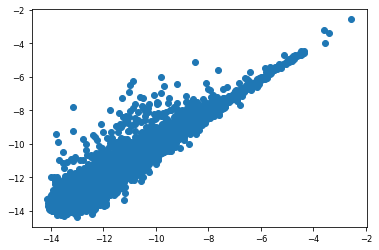

In [36]:
plt.scatter(log_means_1, log_means_2)

In [37]:
def simulate_two_datasets(x_param_1 ,x_param_2, Nc_1, Nc_2, n_cells, q, diff='mean'):
    
    log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
    log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])
    reg_1 = memento.estimator._fit_mv_regressor(np.exp(log_means_1), np.exp(log_variances_1))
    reg_2 = memento.estimator._fit_mv_regressor(np.exp(log_means_2), np.exp(log_variances_2))
    rv_1 = memento.estimator._residual_variance(np.exp(log_means_1), np.exp(log_variances_1), reg_1)
    rv_2 = memento.estimator._residual_variance(np.exp(log_means_2), np.exp(log_variances_2), reg_2)
    f_1 = np.poly1d(reg_1)
    f_2 = np.poly1d(reg_2)
    
    if diff == 'null':
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'mean':
        avg_means = (log_means_1+log_means_2)/2
        null_idxs = np.absolute(log_means_1-log_means_2) < 0.25
        log_means_1[null_idxs] = avg_means[null_idxs]
        log_means_2[null_idxs] = avg_means[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'variability':
        avg_rvs = np.exp((np.log(rv_1)+np.log(rv_2))/2)
        null_idxs = np.absolute(np.log(rv_1)-np.log(rv_2)) < 0.5
        rv_1[null_idxs] = avg_rvs[null_idxs]
        rv_2[null_idxs] = avg_rvs[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'correlation':
        num_dc_genes = 400
        norm_cov_1 = cov2corr(make_spd_matrix(num_dc_genes))
        norm_cov_2 = cov2corr(make_spd_matrix(num_dc_genes))
        es_diff = norm_cov_2 - norm_cov_1
        with open(data_path + 'dc_true_effect_size.pkl', 'wb') as f:
            pkl.dump(es_diff, f)
    
    data_1 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_1)*Nc_1.mean(),
        variances=(np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2,
        Nc=Nc_1,
        norm_cov=norm_cov_1)
    
    data_2 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_2)*Nc_2.mean(),
        variances=(np.exp(log_variances_2) + np.exp(log_means_2)**2)*(Nc_2**2).mean() - np.exp(log_means_2)**2*Nc_2.mean()**2,
        Nc=Nc_2,
        norm_cov=norm_cov_2)
    
    true_data = np.vstack([data_1, data_2])
    true_data[(true_data < 0) | (true_data > 500)] = 0
    _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')
    
    anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
    anndata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
    anndata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], anndata.shape[0])
    
    if diff != 'correlation':
        anndata.var['is_null'] = null_idxs
        anndata.var['is_sig'] = ~anndata.var['is_null']
    
    if diff == 'correlation':
        return true_data, anndata, None
    else:
        return anndata, None

    


### Simulate cells for DE

In [38]:
# %%time
# de_sim_adata, de_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=250, q=q, diff='mean')
# de_sim_adata.write(data_path + 'de.h5ad')

### Simulate cells for DV

In [39]:
# dv_sim_adata, dv_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=1000, q=q, diff='variability')
# dv_sim_adata.write(data_path + 'dv.h5ad')

### Simulate cells for DC

In [40]:
true_data, dc_sim_adata, null_idxs = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=1000, q=q, diff='correlation')
dc_sim_adata.write(data_path + 'dc.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical


### Try to simulate

In [153]:
def convert_params_nb(mu, theta):
	"""
	Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

	See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
	"""
	r = theta
	var = mu + 1 / r * mu ** 2
	p = (var - mu) / var
	return r, 1 - p

In [332]:
##### m = (np.exp(log_means_1)*Nc_1.mean())[:50]
v = ((np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2)[:50]

d = (v - m)/m**2
d[d < 0] = 1e-5
t = 1/d

num_dc_genes = 50
norm_cov = make_spd_matrix(50)
norm_cov = cov2corr(norm_cov)
# norm_cov = np.eye(50)
# norm_cov2 = cov2corr(make_spd_matrix(50))
# norm_cov_avg = (norm_cov + norm_cov2)/2

# np.fill_diagonal(norm_cov, 1)
# norm_cov[:3, :3] = -0.8
# norm_cov = np.random.random((num_dc_genes, num_dc_genes))


<AxesSubplot:ylabel='Density'>

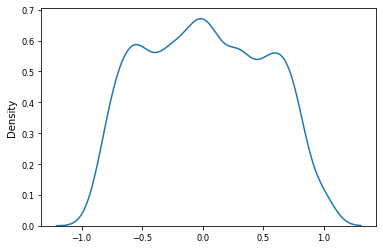

In [334]:
sns.kdeplot(norm_cov.ravel())

In [324]:
import numpy as np

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [325]:
gaussian_variables = stats.multivariate_normal.rvs(mean=np.zeros(50), cov=norm_cov, size=1000)
uniform_variables = stats.norm.cdf(gaussian_variables)
nbinom_variables = stats.nbinom.ppf(uniform_variables, *convert_params_nb(m, t))




In [326]:
stats.pearsonr(nbinom_variables[:, 0], nbinom_variables[:, 1])

(0.051742522620752705, 0.10198800955309255)

<AxesSubplot:ylabel='Density'>

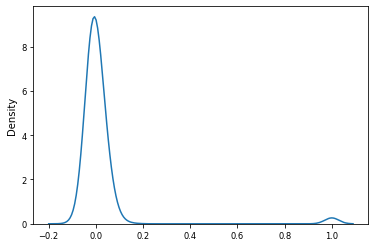

In [327]:
sns.kdeplot(np.corrcoef(nbinom_variables, rowvar=False).ravel())


<AxesSubplot:ylabel='Density'>

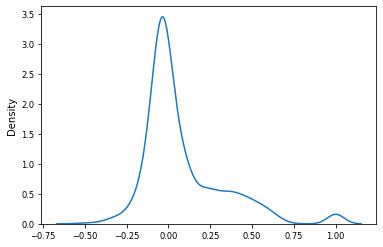

In [322]:
sns.kdeplot(np.corrcoef(nbinom_variables, rowvar=False).ravel())


In [261]:
num_dc_genes = 50
norm_cov_1 = np.ones((num_dc_genes, num_dc_genes))*0
np.fill_diagonal(norm_cov_1, 1)

In [34]:
a = np.corrcoef(dc_sim_adata[:1000, :].X.toarray(), rowvar=False)
b = np.corrcoef(dc_sim_adata[1000:, :].X.toarray(), rowvar=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [35]:
diff = a-b

<AxesSubplot:ylabel='Density'>

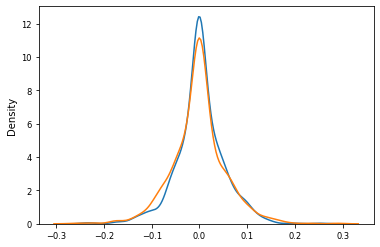

In [36]:
sns.kdeplot(np.random.choice(diff[null_idxs], 1000))
sns.kdeplot(np.random.choice(diff[~null_idxs], 1000))

### Power calculation (maybe)

In [ ]:
def calculate_power(n_cells, test='mean', test_null=False):
    
    sim_adata, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff=test if not test_null else 'null')
        
    schypo.create_groups(
        sim_adata,
        q=q,
        label_columns=['ct_real'], 
        inplace=True)
    
    schypo.compute_1d_moments(
        sim_adata, 
        inplace=True, 
        filter_genes=False, 
        residual_var=True,
        filter_mean_thresh=0.0, 
        min_perc_group=.9)
        
    if test == 'mean':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)

        power = (sim_adata.uns['schypo']['1d_ht']['mean_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['mean_asl']
        
    if test == 'variability':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        power = (sim_adata.uns['schypo']['1d_ht']['var_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['var_asl']
        
    if test == 'correlation':
        
        schypo.compute_2d_moments(
            sim_adata, 
            inplace=True, 
            gene_1=np.arange(50).astype(str).tolist(),
            gene_2=np.arange(50).astype(str).tolist())
        
        schypo.ht_2d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        c_pv = sim_adata.uns['schypo']['2d_ht']['corr_asl'][:50, :50]
        power = (c_pv[change_indices] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['2d_ht']['corr_asl']
                
    return power, pvals, sim_adata

In [ ]:
mean_power, var_power, corr_power = [], [], []
n_cells_list = np.logspace(2, 5, 25).astype(int)
for n_cells in n_cells_list:
    
    print(n_cells)
    
    mean_power.append(calculate_power(n_cells, test='mean')[0])
    var_power.append(calculate_power(n_cells, test='variability')[0])
    corr_power.append(calculate_power(n_cells, test='correlation')[0])

with open('temp.pkl', 'wb') as f:
    pkl.dump([mean_power, var_power, corr_power], f)

In [242]:
n_cells_list = np.logspace(2, 5, 25).astype(int)

with open('/data/parameter_estimation/simulation/power_analysis.pkl', 'rb') as f:
    mean_power, var_power, corr_power = pkl.load(f)

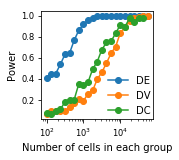

In [252]:
plt.figure(figsize=(2, 2))
plt.plot(n_cells_list[:23], mean_power, '-o')
plt.plot(n_cells_list[:23], var_power, '-o')
plt.plot(n_cells_list[:22], corr_power, '-o')
plt.xscale('log')
plt.xlabel('Number of cells in each group')
plt.ylabel('Power')
plt.legend(['DE', 'DV', 'DC'], loc='lower right', bbox_to_anchor=(0.56, -0.05, 0.5, 0.5), frameon=False)
plt.savefig(fig_path + 'power.pdf', bbox_inches='tight')

In [76]:
# with open('temp.pkl', 'wb') as f:
#     pkl.dump([mean_power, var_power, corr_power], f)

### Generate p-value histograms

In [198]:
adata = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
# data = adata.X.copy()
# relative_data = data.toarray()/data.sum(axis=1)

n_cells = 5000
q=0.07
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.001)

In [199]:
sim_adata_mean, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='mean')

In [200]:
print(sim_adata_mean.shape)

schypo.create_groups(
    sim_adata_mean,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_mean, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.00001, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_mean, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10805)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 1030 tasks      | elapsed:   26.0s
[Parallel(n_jobs=6)]: Done 1734 tasks      | elapsed:   37.1s
[Parallel(n_jobs=6)]: Done 2566 tasks      | elapsed:   50.3s
[Parallel(n_jobs=6)]: Done 3526 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 4614 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 5830 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 7174 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 8646 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 10246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 10798 out of 10798 | elapsed:  3.0min finished


In [201]:
sim_adata_mean.write('/data/parameter_estimation/simulation/sim_mean.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [147]:
sim_adata_var, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='variability')

schypo.create_groups(
    sim_adata_var,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_var, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.05, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_var, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10800)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 988 tasks      | elapsed:   28.4s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   45.8s
[Parallel(n_jobs=6)]: Done 2268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2364 out of 2375 | elapsed:  1.1min remaining:    0.3s
[Parallel(n_jobs=6)]: Done 2375 out of 2375 | elapsed:  1.2min finished


In [158]:
sim_adata_var.write('/data/parameter_estimation/simulation/sim_var.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [225]:
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.05)
sim_adata_corr, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='correlation')


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [226]:
schypo.create_groups(
    sim_adata_corr,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_corr, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.0, 
    min_perc_group=.9)
schypo.compute_2d_moments(
    sim_adata_corr, 
    inplace=True, 
    gene_1=np.arange(100).astype(str).tolist(),
    gene_2=np.arange(100).astype(str).tolist())
schypo.ht_2d_moments(
    sim_adata_corr, 
    formula_like='1 + ct_real',
    cov_column='ct_real',
    num_boot=5000,
    num_cpus=6,
    verbose=3)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   42.1s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 4950 out of 4950 | elapsed:  4.8min finished


In [227]:
sim_adata_corr.uns['null'] = corr_asl_null

In [228]:
sim_adata_corr.write('/data/parameter_estimation/simulation/sim_corr.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


### Plot p-value histograms

In [194]:
sim_adata_var = sc.read('/data/parameter_estimation/simulation/sim_var.h5ad')
var_asl = sim_adata_var.uns['schypo']['1d_ht']['var_asl']

In [202]:
sim_adata_mean = sc.read('/data/parameter_estimation/simulation/sim_mean.h5ad')
mean_asl = sim_adata_mean.uns['schypo']['1d_ht']['mean_asl']

In [231]:
sim_adata_corr = sc.read('/data/parameter_estimation/simulation/sim_corr.h5ad')
corr_asl = sim_adata_corr.uns['schypo']['2d_ht']['corr_asl'].ravel()
corr_null_asl = sim_adata_corr.uns['null'].ravel()

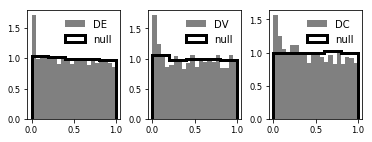

In [253]:
plt.figure(figsize=(6, 2));
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1);
plt.hist(mean_asl, bins=20, density=True, color='grey', label='DE');
plt.hist(mean_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 2);
plt.hist(var_asl, bins=20, density=True, color='grey', label='DV');
plt.hist(var_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 3);
plt.hist(corr_asl.ravel(), density=True, color='grey', bins=20, label='DC');
plt.hist(corr_asl_null.ravel(), bins=5, density=True, color='black', label='null', histtype='step', linewidth=3);
plt.legend(frameon=False)
plt.savefig(fig_path + 'calibration_histograms.pdf', bbox_inches='tight')